In [1]:
from nn_hmc_3d import NN_HMC
import dill
import numpy as np
import IPython
import jax.random as random
import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt
import h5py
from igm_emulator.emulator.plotVis import v_bins
from igm_emulator.emulator.emulator_run import nn_emulator
import os
'''
load model and auto-corr
'''
redshift = 5.4

# get the appropriate string and pathlength for chosen redshift
zs = np.array([5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0])
z_idx = np.argmin(np.abs(zs - redshift))
z_strings = ['z54', 'z55', 'z56', 'z57', 'z58', 'z59', 'z6']
z_string = z_strings[z_idx]
in_path_hdf5 = '/home/zhenyujin/igm_emulator/igm_emulator/emulator/best_params/'
f = h5py.File(in_path_hdf5 + f'z{redshift}_nn_savefile.hdf5', 'r')
emu_name = f'{z_string}_best_param_training_768.p'
#IPython.embed()

best_params = dill.load(open(in_path_hdf5 + emu_name, 'rb'))
meanX = np.asarray(f['data']['meanX'])
stdX = np.asarray(f['data']['stdX'])
meanY = np.asarray(f['data']['meanY'])
stdY =  np.asarray(f['data']['stdY'])
print(meanX)
#best_params = load(f)
#print(f['performance']['residuals'])
#print(f['best_params']['custom_linear/~/linear_0']['w'])
#print(load(f'/home/zhenyujin/igm_emulator/igm_emulator/emulator/best_params/z{redshift}_nn_savefile.hdf5'))

in_path = f'/mnt/quasar2/mawolfson/correlation_funct/temp_gamma/final/{z_string}/final_135/'
n_paths = np.array([17, 16, 16, 15, 15, 15, 14])
n_path = n_paths[z_idx]
vbins = v_bins
param_in_path = '/mnt/quasar2/mawolfson/correlation_funct/temp_gamma/final/'
param_dict = dill.load(open(param_in_path + f'{z_string}_params.p', 'rb'))

fobs = param_dict['fobs']  # average observed flux <F> ~ Gamma_HI
log_T0s = param_dict['log_T0s']  # log(T_0) from temperature - density relation
T0s = np.exp(log_T0s)
gammas = param_dict['gammas']  # gamma from temperature - density relation

T0_idx = 11 #0-14
g_idx = 4 #0-8
f_idx = 7 #0-8

like_name = f'likelihood_dicts_R_30000_nf_9_T{T0_idx}_G{g_idx}_SNR0_F{f_idx}_ncovar_500000_P{n_path}_set_bins_4.p'
like_dict = dill.load(open(in_path + like_name, 'rb'))
theta_true = [fobs[f_idx], T0s[T0_idx], gammas[g_idx]]

Layers: [100, 100, 100, 276]
Activation: <function leaky_relu at 0x7ff7b5bf1e18>
L2 regularization lambda: 0.0001
meanX = [8.400e-02 9.149e+03 1.352e+00]
stdX = [1.36930639e-02 5.50374022e+03 6.02494813e-01]
train: (768, 3)
(358, 276)
[8.400e-02 9.149e+03 1.352e+00]


In [2]:
print(theta_true)

[0.099, 63.53569309711353, 1.3520000000000003]


In [3]:
theta=jnp.array([theta_true,theta_true,theta_true])
theta_i=theta.squeeze()
print(theta)
print(theta.shape)
print(theta_i.shape)

[[ 0.099     63.5356931  1.352    ]
 [ 0.099     63.5356931  1.352    ]
 [ 0.099     63.5356931  1.352    ]]
(3, 3)
(3, 3)


<class 'list'>


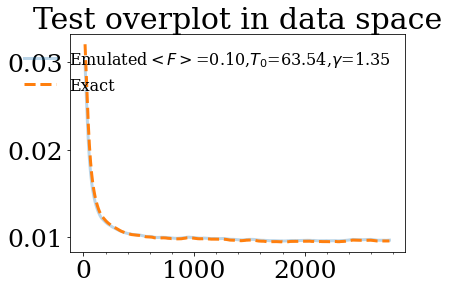

In [4]:
flux = like_dict['mean_data']
print(type(theta_true))

model = nn_emulator(best_params, theta_true)

fig2, axs2 = plt.subplots(1, 1)
axs2.plot(vbins, model, label=f'Emulated' r'$<F>$='f'{theta_true[0]:.2f},'
                                                     r'$T_0$='f'{theta_true[1]:.2f},'
                                                     r'$\gamma$='f'{theta_true[2]:.2f}', alpha=0.3)
axs2.plot(vbins, flux, label=f'Exact', linestyle='--')
plt.title('Test overplot in data space')
plt.legend()
plt.show()

In [ ]:
    nn = NN_HMC(vbins,best_params,T0s,gammas,fobs,like_dict)
    key = random.PRNGKey(42)
    key, subkey = random.split(key)
    x_samples, samples, ln_probs, neff, neff_mean, \
    sec_per_neff, ms_per_step, r_hat, r_hat_mean, \
    hmc_num_steps, hmc_tree_depth, runtime = nn.mcmc_one(key, theta_true, flux)

/home/zhenyujin/igm_emulator/igm_emulator/hmc/nn_hmc_3d.py:117: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  jit_model_args=True, chain_method='parallel')  # chain_method='sequential' chain_method='vectorized'


true theta:[0.099, 63.53569309711353, 1.3520000000000003]
true x:[1.94591015e+00 2.00352811e+00 4.44089210e-16]
theta draw=Traced<ShapedArray(float64[3])>with<JVPTrace(level=2/1)>
  with primal = Traced<ShapedArray(float64[3]):JaxprTrace(level=1/1)>
       tangent = Traced<ShapedArray(float64[3]):JaxprTrace(level=1/1)>
prior theta:Traced<ShapedArray(float64[3])>with<JVPTrace(level=2/2)>
  with primal = Traced<ShapedArray(float64[3]):JaxprTrace(level=1/2)>
       tangent = Traced<ShapedArray(float64[3]):JaxprTrace(level=1/2)>
x=Traced<ShapedArray(float64[3])>with<JVPTrace(level=2/2)>
  with primal = Traced<ShapedArray(float64[3])>with<DynamicJaxprTrace(level=0/2)>
       tangent = Traced<ShapedArray(float64[3]):JaxprTrace(level=1/2)>
Prior=Traced<ShapedArray(float64[])>with<JVPTrace(level=2/2)>
  with primal = Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=0/2)>
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=1/2)>
Log_likelihood=Traced<ShapedArray(float64[])

  0%|          | 0/2000 [00:00<?, ?it/s]

theta draw=Traced<ShapedArray(float64[3])>with<JVPTrace(level=4/2)>
  with primal = Traced<ShapedArray(float64[3]):JaxprTrace(level=3/2)>
       tangent = Traced<ShapedArray(float64[3]):JaxprTrace(level=3/2)>
prior theta:Traced<ShapedArray(float64[3])>with<JVPTrace(level=4/3)>
  with primal = Traced<ShapedArray(float64[3]):JaxprTrace(level=3/3)>
       tangent = Traced<ShapedArray(float64[3]):JaxprTrace(level=3/3)>
x=Traced<ShapedArray(float64[3])>with<JVPTrace(level=4/3)>
  with primal = Traced<ShapedArray(float64[3])>with<DynamicJaxprTrace(level=2/3)>
       tangent = Traced<ShapedArray(float64[3]):JaxprTrace(level=3/3)>
Prior=Traced<ShapedArray(float64[])>with<JVPTrace(level=4/3)>
  with primal = Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=2/3)>
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=3/3)>
Log_likelihood=Traced<ShapedArray(float64[])>with<JVPTrace(level=4/3)>
  with primal = Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=2/3)>
    

warmup:  20%|██        | 402/2000 [01:04<04:58,  5.36it/s, 15 steps of size 2.46e-01. acc. prob=0.78]  

In [ ]:
nn.plot_HMC(x_samples,samples,theta_true,"jit_2000_3")